In [1]:
# Step 1: Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Step 2: Load dataset
df = pd.read_csv("t20i_Matches_Data_final.csv")

# Step 3: Select features (X) and target (y)
X = df[['Team1 Runs Scored', 'Team2 Runs Scored', 'Match Venue (Country)','Team1 Name','Team2 Name','Toss Winner']]
y = df['Match Winner']

# Step 4: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Create preprocessing + model pipeline
# OneHotEncode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Team1 Name', 'Team2 Name', 'Match Venue (Country)'])
    ]
)

# Combine preprocessing and model into a pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial'))
])

# Step 6: Train the model
model.fit(X_train, y_train)

# Step 7: Make predictions
y_pred = model.predict(X_test)

# Step 8: Evaluate the model
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

# Step 9: Print results
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion Matrix:
 [[10  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  3  0]
 [ 0  0  0 ...  0  0  1]]
Accuracy: 0.6146435452793835
Precision: 0.5221955117848753
Recall: 0.5187569083486351
F1 Score: 0.4930446780689591


<Figure size 1200x1000 with 0 Axes>

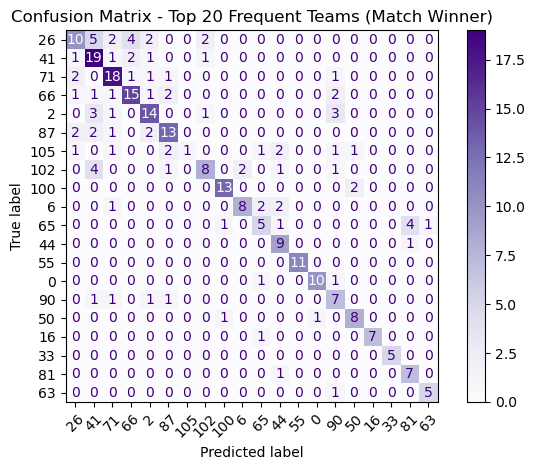

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Find top 20 most common teams in y_test
top = y_test.value_counts().head(20).index
mask = y_test.isin(top)
y_test_top = y_test[mask]
y_pred_top = pd.Series(y_pred, index=y_test.index)[mask]

labels_top = np.array(top)

cm_top = confusion_matrix(y_test_top, y_pred_top, labels=labels_top)
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_top, display_labels=labels_top)
disp.plot(cmap='Purples', xticks_rotation=45, colorbar=True)
plt.title('Confusion Matrix - Top 20 Frequent Teams (Match Winner)')
plt.tight_layout()
plt.show()


# logistic regression (GridSearch CV)

In [3]:
# Step 1: Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)

# Step 2: Load dataset
df = pd.read_csv("t20i_Matches_Data_final.csv")

# Step 3: Select features and target variable
X = df[['Team1 Name', 'Team2 Name', 'Match Venue (Country)']].copy()
y = df['Match Winner'].copy()

# Step 4: Convert and clean missing
for col in X.columns:
    X[col] = X[col].fillna("Unknown").astype(str)
y = y.fillna("Unknown").astype(str)

# Step 5: Remove rare classes (only 1 sample)
valid_labels = y.value_counts()[y.value_counts() >= 2].index
mask = y.isin(valid_labels)
X, y = X[mask], y[mask]
print(f"Removed {len(df) - len(X)} rows with rare classes.")

# Step 6: Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 7: Preprocess categorical features
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), X.columns)]
)

# Step 8: Create pipeline with Logistic Regression
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        solver="lbfgs",          # fixed solver
        penalty="l2",            # fixed penalty
        class_weight="balanced", # handle imbalance
        max_iter=5000
    ))
])

# Step 9: Define ONE hyperparameter to tune
param_grid = {
    "classifier__C": [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
}

# Step 10: GridSearchCV (only one parameter)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Step 11: Fit Grid Search
grid_search.fit(X_train, y_train)

print("\n=== Grid Search Results (Single Hyperparameter) ===")
print(f"Best C: {grid_search.best_params_['classifier__C']}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Step 12: Evaluate best model on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\n--- Final Test Performance ---")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")



Removed 10 rows with rare classes.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



=== Grid Search Results (Single Hyperparameter) ===
Best C: 1.0
Best Cross-Validation Accuracy: 0.6008

--- Final Test Performance ---
Accuracy : 0.6306
Precision: 0.6317
Recall   : 0.6306
F1 Score : 0.6169


<Figure size 1200x1000 with 0 Axes>

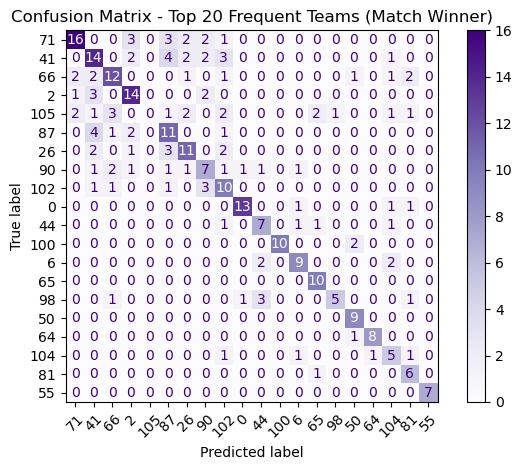

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Find top 20 most common teams in y_test
top = y_test.value_counts().head(20).index
mask = y_test.isin(top)
y_test_top = y_test[mask]
y_pred_top = pd.Series(y_pred, index=y_test.index)[mask]

labels_top = np.array(top)

cm_top = confusion_matrix(y_test_top, y_pred_top, labels=labels_top)
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_top, display_labels=labels_top)
disp.plot(cmap='Purples', xticks_rotation=45, colorbar=True)
plt.title('Confusion Matrix - Top 20 Frequent Teams (Match Winner)')
plt.tight_layout()
plt.show()
